In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
#function to convert date into DateTime format
def parser(s):
    return datetime.strptime(s, '%d-%m-%Y')

In [3]:
#read data
df = pd.read_csv('datasets/co2.csv', parse_dates=[0], index_col=0, date_parser=parser)
df.head()

,CO2
Date,
1959-01-31,315.58
1959-02-28,316.39
1959-03-31,316.79
1959-04-30,317.82
1959-05-31,318.39


In [4]:
df.tail()

,CO2
Date,
1987-08-31,347.54
1987-09-30,346.20
1987-10-31,346.20
1987-11-30,347.44
1987-12-31,348.67


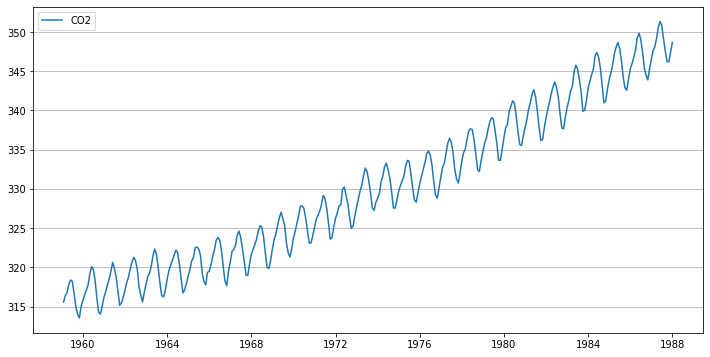

In [5]:
plt.figure('figure',figsize=(12,6))  #Defining figure size for plot
plt.plot(df.CO2, label='CO2')        #plotting data
plt.grid(axis='y')
plt.legend()
plt.show()

# Seasonal Trend Decomposition of Data:

As the the data distribution looks additive in nature, so we will do trend, seasonal and residual decomposition of the data. As our interest lies in catching outliers in the data, we will be focusing on residual plot only.

In [6]:
result = seasonal_decompose(df.CO2,model='additive') #seasonal trend decomposition of dataframe
x = result.resid.index    #time array
y = result.resid.values   #residual array
y[:10], y[-10:]           #first and last 10 elements of residual array

(array([        nan,         nan,         nan,         nan,         nan,
                nan, -0.33090154, -0.02477059,  0.65208953,  0.34319072]),
 array([-0.13128844,  0.03726811,  0.12933656,  0.01644965,         nan,
                nan,         nan,         nan,         nan,         nan]))

As there are 12 'nan' values in y, we will remove that to find some statistical parameters like mean, standard deviation, Q1, Q3 & IQR.

In [7]:
mean = np.mean(y[6:-6])          #mean of residuals
std = np.std(y[6:-6])            #standard deviation of residuals
q1 = np.quantile(y[6:-6],0.25)   #1st quartile of residuals
q3 = np.quantile(y[6:-6],0.75)   #3rd quartile of residuals
iqr = q3-q1                      #Inter Quartile Range

We will define outliers using two metrics
1) Hard Outliers: mean +- 3*standard deviation

2) Soft Outlier: Q1 - 1.5*IQR and Q3 + 1.5*IQR

In [8]:
t = []                   #array for mean +- 3*std reference line
a = []                   #array for Q1 - 1.5*IQR / Q3 - 1.5*IQR reference line

#for loop to append 3*std & 1.5*IQR value as many time as the total data points in original data 
for i in range(len(x)):  
    t.append(3*std)
    a.append(1.5*iqr)
t = np.array(t)
a = np.array(a)

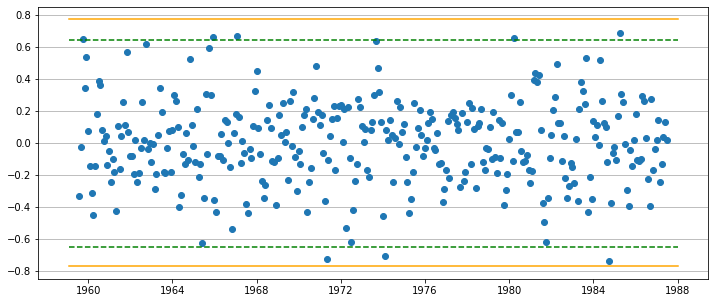

In [9]:
plt.figure('figure',figsize=(12,5))                  #Defining figure size for plot
plt.plot_date(x, y)                                  #Plotting Residuals
plt.plot(x,mean+t, color='orange')                   #Plotting mean + 3*std reference line
plt.plot(x,mean-t, color='orange')                   #Plotting mean - 3*std reference line
plt.plot(x,q1-a, color='green', linestyle='--')      #Plotting q1 - 1.5*IQR reference line
plt.plot(x,q3+a, color='green', linestyle='--')      #Plotting q3 + 1.5*IQR reference line
plt.grid(axis='y')                                   #Plotting grid lines for y-axis
plt.show()

Outliers as per q1 - 1.5*IQR & q3 + 1.5*IQR definition: 8


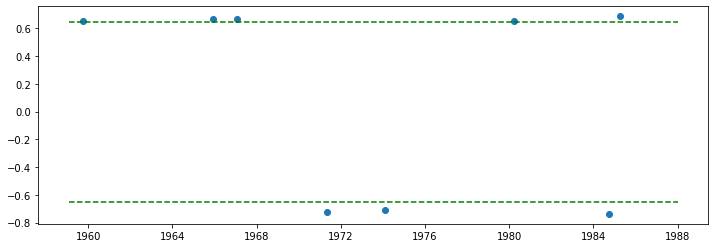

In [10]:
o = []
c = []
for i in range(len(y)):
    if y[i] >= q3+1.5*iqr or y[i]<= q1-1.5*iqr:           #checking whether a point is a soft outlier or not
        o.append(y[i])                                    #list containing outlier value
        c.append(x[i])                                    #list containing outlier date
print("Outliers as per q1 - 1.5*IQR & q3 + 1.5*IQR definition:",len(o))
plt.figure('figure',figsize=(12,4))                       #Defining figure size for plot
plt.plot(x,q1-a, color='green', linestyle='--')           #Plotting q1 - 1.5*IQR reference line
plt.plot(x,q3+a, color='green', linestyle='--')           #Plotting q3 + 1.5*IQR reference line
plt.scatter(c,o)
plt.show()

As seen in the graph and the distribution of the 8 outliers(as per q1 - 1.5*IQR & q3 + 1.5*IQR definition) is pretty evenly spread out. Also the magnitude of these outliers is not large and are very close to the threshold lines. Due to these reasons we will consider this as soft outliers.

The residuals obtained from seasonal decompostion are normally distributed. We will use mean +- 3*standard deviation as the threshold to define hard outliers, because the mean and standard deviation are sensitive to outlier values.

# Injecting Different Types of Anomalies to Data:

In [11]:
#Injecting few anomalies of different types
df.iloc[9,0] = 305        #Global Point Anomaly
df.iloc[-9,0] = 360       #Global Point Anomaly
df.iloc[198,0] = 328.5    #Local Point Anomaly
df.iloc[166,0] = 331      #Local Point Anomaly
#Collective/Subsequence Anomaly
for i in range(250,262):
    df.iloc[i,0] = np.mean(df.iloc[250:262,0]) + np.random.normal(0,1,1)

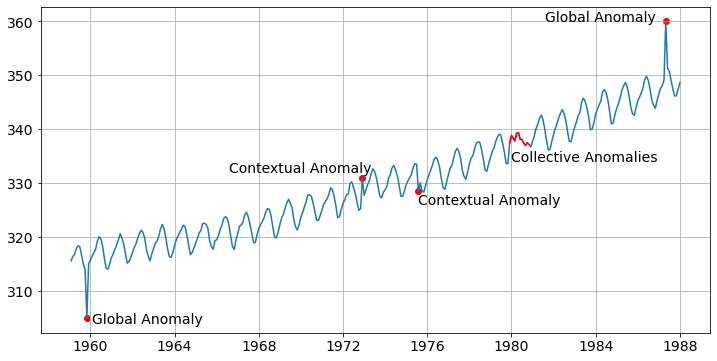

In [12]:
plt.figure('figure',figsize=(12,6))
plt.rc('font', size = 14)
plt.plot(df.iloc[:,0])
plt.scatter(df.index[9], df.iloc[9,0], color='red')
plt.annotate('Global Anomaly',(df.index[12], 304))
plt.scatter(df.index[-9], df.iloc[-9,0], color='red')
plt.annotate('Global Anomaly',(df.index[-78], 360))

plt.scatter(df.index[198], df.iloc[198,0], color='red')
plt.annotate('Contextual Anomaly',(df.index[198], 326))
plt.scatter(df.index[166], df.iloc[166,0], color='red')
plt.annotate('Contextual Anomaly',(df.index[90], 332))

plt.plot(df.index[250:262], df.iloc[250:262,0], color='red')
plt.annotate('Collective Anomalies',(df.index[251], 334))
plt.grid()
plt.show()

# Anomaly Detection using Seasonal Trend Decomposition:

In [13]:
result = seasonal_decompose(df.CO2,model='additive') #seasonal trend decomposition of dataframe
x = result.resid.index    #time array
y = result.resid.values   #residual array

In [14]:
mean = np.mean(y[6:-6])          #mean of residuals
std = np.std(y[6:-6])            #standard deviation of residuals
q1 = np.quantile(y[6:-6],0.25)   #1st quartile of residuals
q3 = np.quantile(y[6:-6],0.75)   #3rd quartile of residuals
iqr = q3-q1                      #Inter Quartile Range

In [15]:
t = []                   #array for mean +- 3*std reference line
a = []                   #array for Q1 - 1.5*IQR / Q3 - 1.5*IQR reference line

#for loop to append 3*std & 1.5*IQR value as many time as the total data points in original data 
for i in range(len(x)):  
    t.append(3*std)
    a.append(1.5*iqr)
t = np.array(t)
a = np.array(a)

In [16]:
o = []
h = []
p = []
s = []
for i in range(len(y)):
    if y[i] >= mean+3*std or y[i]<= mean-3*std:         #checking whether a point is a hard outlier or not
        h.append(y[i])                                  #list containing hard outlier value
        o.append(x[i])                                  #list containing hard outlier date
    elif y[i] >= q3+1.5*iqr or y[i]<= q1-1.5*iqr:       #checking whether a point is a soft outlier or not
        s.append(y[i])                                  #list containing soft outlier value
        p.append(x[i])                                  #list containing soft outlier date

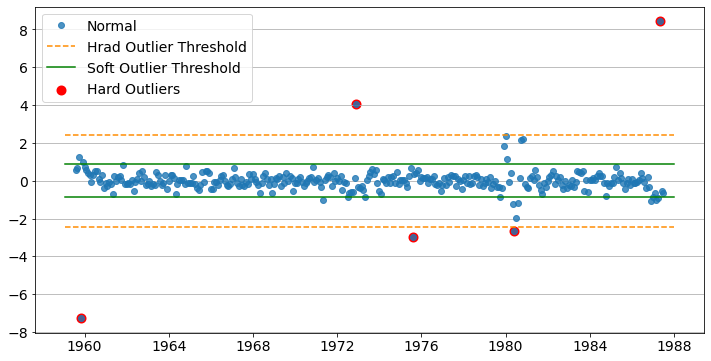

In [17]:
plt.figure('figure',figsize=(12,6))
plt.plot_date(x, y, alpha=0.8, label = 'Normal')
plt.plot(x,mean+t, color='darkorange', linestyle='--', label = 'Hrad Outlier Threshold')
plt.plot(x,mean-t, color='darkorange', linestyle='--')
plt.plot(x,q1-a, color='green', label = 'Soft Outlier Threshold')
plt.plot(x,q3+a, color='green')
plt.scatter(o,h, color='red', linewidths=4, label = 'Hard Outliers')
plt.grid(axis='y')
plt.legend()
plt.show()

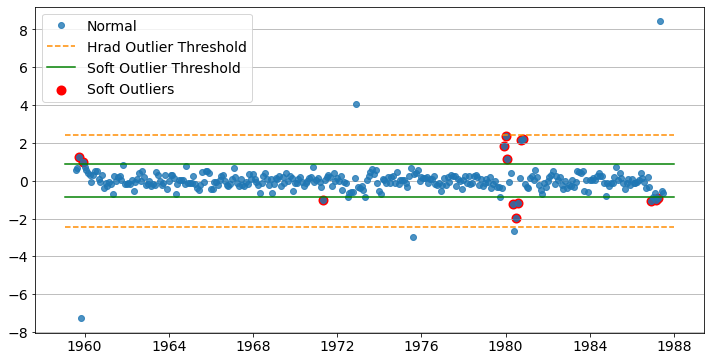

In [18]:
plt.figure('figure',figsize=(12,6))
plt.plot_date(x, y, alpha=0.8, label = 'Normal')
plt.plot(x,mean+t, color='darkorange', linestyle='--', label = 'Hrad Outlier Threshold')
plt.plot(x,mean-t, color='darkorange', linestyle='--')
plt.plot(x,q1-a, color='green', label = 'Soft Outlier Threshold')
plt.plot(x,q3+a, color='green')
plt.scatter(p,s, color='red', linewidths=4, label = 'Soft Outliers')
plt.grid(axis='y')
plt.legend()
plt.show()

# Anomaly Detection using Isolation Forest:

In [19]:
# Importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [20]:
outliers_fraction = 0.046   #Total no. of injected anomalies(16) / Total obsevations(348) = 0.046
#Scalar transformion of data
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [21]:
# training isolation forest model
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.046)

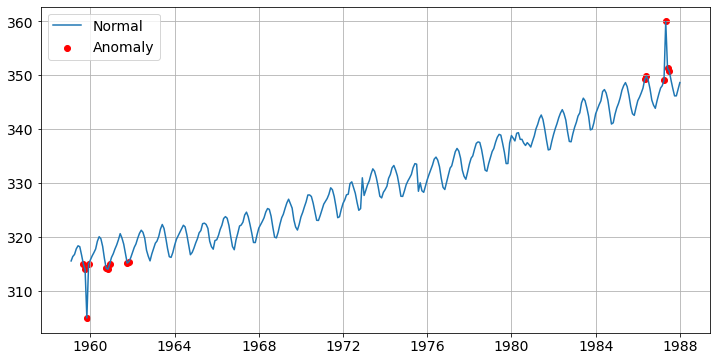

In [22]:
#predicting using trained isolation forest model
df['anomaly'] = model.predict(data)

z = df.loc[df['anomaly'] == -1, ['CO2']]  #array containing anomaly values and their corrosponding index

plt.figure('figure',figsize=(12,6))
plt.plot(df.index, df['CO2'], label = 'Normal')
plt.scatter(z.index,z['CO2'], color='red', label = 'Anomaly')
plt.grid()
plt.legend()
plt.show()

As you can see in the above graph, the model doesn't do a good job for predicting local and collective anomalies and instead exaggerates the global anomalies on both ends.

# Anomaly Treatment using Seasonal Trend Decomposition:

In [23]:
result = seasonal_decompose(df.CO2,model='additive') #seasonal trend decomposition of dataframe
xt = result.trend.index                              #time array
yt = result.trend.values                             #trend array
xs = result.seasonal.index                           #time array
ys = result.seasonal.values                          #seasonality array
ts = dict(zip(xt,(yt+ys)))                           #Dictionary containing trend+seasonality value of the timeseries

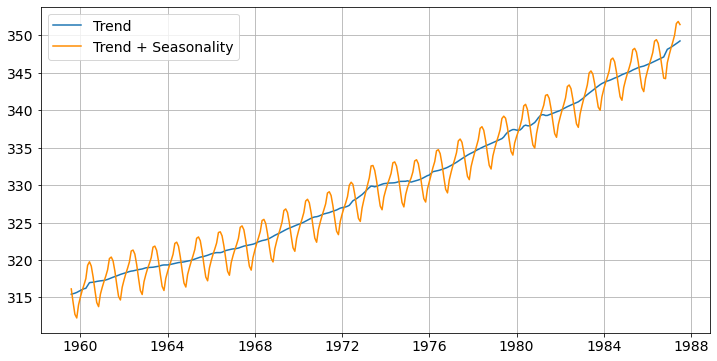

In [24]:
plt.figure('figure',figsize=(12,6))                                  #Defining figure size for plot
plt.plot(xt, yt, label='Trend')                                      #Plotting trend
plt.plot(xs, yt+ys, color='darkorange', label='Trend + Seasonality') #Plotting trend + seasonality
plt.grid()
plt.legend()
plt.show()

In [25]:
#replacing outliers with trend+seasonality
o = []
h = []
p = []
s = []
for i in range(len(y)):
    if y[i] >= mean+3*std or y[i]<= mean-3*std:         #checking whether a point is a hard outlier or not
        h.append(y[i])                                  #list containing hard outlier value
        o.append(x[i])                                  #list containing hard outlier date
    elif y[i] >= q3+1.5*iqr or y[i]<= q1-1.5*iqr:       #checking whether a point is a soft outlier or not
        s.append(y[i])                                  #list containing soft outlier value
        p.append(x[i])                                  #list containing soft outlier date

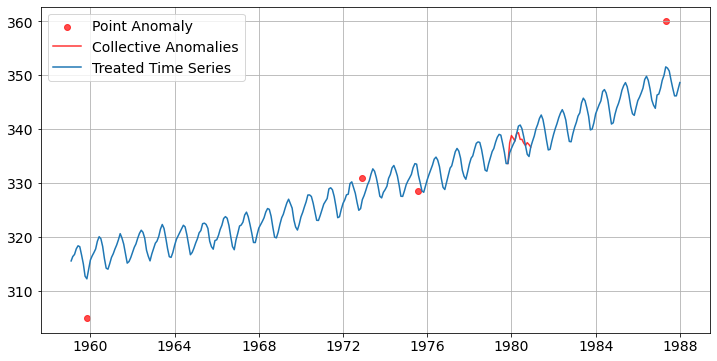

In [26]:
plt.figure('figure',figsize=(12,6))
plt.rc('font', size = 14)

#Plotting injected outliers
plt.scatter(df.index[9], df.iloc[9,0], color='red', alpha=0.7)
plt.scatter(df.index[-9], df.iloc[-9,0], color='red', alpha=0.7)

plt.scatter(df.index[198], df.iloc[198,0], color='red', alpha=0.7)
plt.scatter(df.index[166], df.iloc[166,0], color='red', alpha=0.7, label="Point Anomaly")

plt.plot(df.index[249:263], df.iloc[249:263,0], color='red', alpha=0.8, label="Collective Anomalies")


#Treatment of hard outliers 
for k in o:
    df.loc[k,['CO2']] = ts[k]
#Treatment of soft outliers
for k in p:
    df.loc[k,['CO2']] = ts[k]
    
plt.plot(df.CO2, label='Treated Time Series')               #Plotting the time series after treating outliers
plt.grid()
plt.legend()
plt.show()